# ДЗ2. Обзор основных алгоритмов машинного обучения

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - **ROC AUC**, целевая переменная - **isFraud**.  

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import Pool
from catboost.utils import get_roc_curve

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, \
                             classification_report, plot_confusion_matrix, recall_score, \
                             plot_precision_recall_curve, precision_recall_curve, plot_roc_curve)

import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('./data/assignment_2_train.csv')
test = pd.read_csv('./data/assignment_2_test.csv')

In [3]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [6]:
test.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.000010e+05,100001.000000,1.000010e+05,100001.000000,100001.000000,98325.000000,99185.000000,98701.000000,88300.000000,88300.000000,...,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000
mean,3.337000e+06,0.038040,8.696663e+06,140.674821,9882.200528,357.652672,153.271785,198.466672,289.507758,86.863941,...,0.192944,81.733429,123.824365,91.572815,6.744021,36.245940,11.969737,47.597468,52.675413,48.497675
std,2.886795e+04,0.191293,7.603909e+05,240.272633,4867.290775,156.984512,11.512903,41.495035,101.589641,2.143002,...,0.606917,715.898781,777.526194,718.203590,214.832591,269.734936,216.315923,597.985868,600.451426,598.024560
min,3.287000e+06,0.000000,7.415038e+06,0.251000,1004.000000,100.000000,100.000000,100.000000,104.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.312000e+06,0.000000,8.023328e+06,44.529000,6019.000000,206.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.337000e+06,0.000000,8.630067e+06,73.970000,9633.000000,360.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.362000e+06,0.000000,9.346592e+06,134.950000,14065.000000,500.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,79.750000,39.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.387000e+06,1.000000,1.009155e+07,5543.230000,18395.000000,600.000000,229.000000,237.000000,536.000000,96.000000,...,6.000000,35176.500000,35176.500000,35176.500000,12307.500000,12307.500000,12307.500000,25000.000000,25000.000000,25000.000000


## XGBoost

**Задание 1:** отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [7]:
# Выберем только числовые признаки
target = train['isFraud']
num_features = train.select_dtypes(include=[np.number])
num_features = num_features.drop(['isFraud', 'TransactionID'], axis=1)
num_features.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Разобьем выборку
X_train, X_valid = train_test_split(num_features, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 378), (36000, 378), (144000,), (36000,))

In [9]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(data=X_valid, label=y_valid, enable_categorical=True)

In [10]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 27,
}

In [11]:
# Обучим модель
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000, # equivalent n_estimators
    early_stopping_rounds=30,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.64988	valid-auc:0.65040
[10]	train-auc:0.78992	valid-auc:0.79060
[20]	train-auc:0.83706	valid-auc:0.83095
[30]	train-auc:0.85855	valid-auc:0.85474
[40]	train-auc:0.87409	valid-auc:0.86766
[50]	train-auc:0.88183	valid-auc:0.87420
[60]	train-auc:0.88911	valid-auc:0.88097
[70]	train-auc:0.89350	valid-auc:0.88428
[80]	train-auc:0.89578	valid-auc:0.88621
[90]	train-auc:0.89802	valid-auc:0.88810
[100]	train-auc:0.90013	valid-auc:0.88967
[110]	train-auc:0.90258	valid-auc:0.89196
[120]	train-auc:0.90431	valid-auc:0.89360
[130]	train-auc:0.90565	valid-auc:0.89511
[140]	train-auc:0.90705	valid-auc:0.89655
[150]	train-auc:0.90824	valid-auc:0.89758
[160]	train-auc:0.90953	valid-auc:0.89858
[170]	train-auc:0.91004	valid-auc:0.89892
[180]	train-auc:0.91004	valid-auc:0.89892
[190]	train-auc:0.91004	valid-auc:0.89892
[197]	train-auc:0.91004	valid-auc:0.89892


**Вывод:** Метрика перестала улучшаться на валидационной выборке на 180 итерации.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

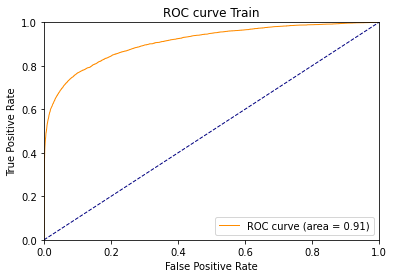

In [12]:
# Строим ROC-кривую
pred_proba_test = model.predict(dtrain)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

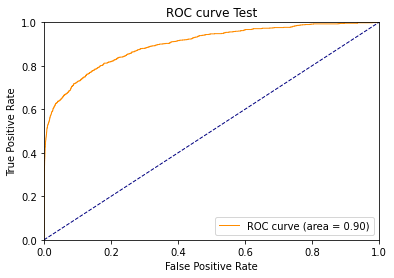

In [13]:
# Строим ROC-кривую
pred_proba_test = model.predict(dvalid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## XGBoost + Категориальные признаки

**Задание 2:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [14]:
# Посмотрим на категориальные признаки
obj_features = train.select_dtypes(include=[np.object])
obj_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [15]:
# Используем get_dummies для преобразования категориальных признаков
obj_dum_features = obj_features.copy()
obj_dum_features = pd.get_dummies(obj_dum_features, dummy_na=True)
obj_dum_features.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1


In [16]:
train = pd.merge(num_features, obj_dum_features, how ='inner', on=num_features.index)
train.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,0,0,0,1,0,0,1,0,0,1
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0,0,0,1,0,0,1,0,0,1


In [17]:
# Разобьем выборку
X_train, X_valid = train_test_split(train, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 544), (36000, 544), (144000,), (36000,))

In [18]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(data=X_valid, label=y_valid, enable_categorical=True)

In [19]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 27,
}

In [20]:
# Обучим модель
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000, # equivalent n_estimators
    early_stopping_rounds=30,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.64988	valid-auc:0.65040
[10]	train-auc:0.78992	valid-auc:0.79060
[20]	train-auc:0.83706	valid-auc:0.83096
[30]	train-auc:0.86458	valid-auc:0.85982
[40]	train-auc:0.87584	valid-auc:0.86901
[50]	train-auc:0.88851	valid-auc:0.88112
[60]	train-auc:0.89542	valid-auc:0.88543
[70]	train-auc:0.90124	valid-auc:0.89092
[80]	train-auc:0.90518	valid-auc:0.89394
[90]	train-auc:0.90745	valid-auc:0.89559
[100]	train-auc:0.90977	valid-auc:0.89781
[110]	train-auc:0.91223	valid-auc:0.89931
[120]	train-auc:0.91402	valid-auc:0.90047
[130]	train-auc:0.91547	valid-auc:0.90161
[140]	train-auc:0.91683	valid-auc:0.90267
[150]	train-auc:0.91761	valid-auc:0.90332
[160]	train-auc:0.91876	valid-auc:0.90447
[170]	train-auc:0.91989	valid-auc:0.90528
[180]	train-auc:0.92073	valid-auc:0.90580
[190]	train-auc:0.92112	valid-auc:0.90651
[200]	train-auc:0.92112	valid-auc:0.90651
[210]	train-auc:0.92112	valid-auc:0.90651
[215]	train-auc:0.92112	valid-auc:0.90651


**Вывод:** Метрика перестала улучшаться на валидационной выборке на 200 итерации. При этом добавление категориальных фичей повысило качество модели с 0.89892 до 0.90651.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

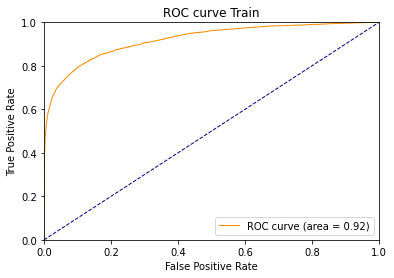

In [21]:
# Строим ROC-кривую
pred_proba_test = model.predict(dtrain)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

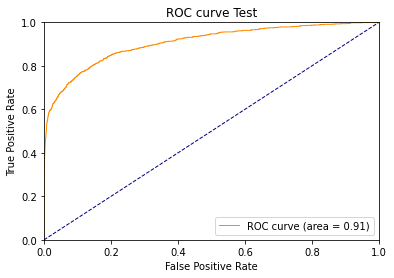

In [22]:
# Строим ROC-кривую
pred_proba_test = model.predict(dvalid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## LightGBM

**Задание 4:** для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [23]:
train = pd.read_csv('./data/assignment_2_train.csv')
test = pd.read_csv('./data/assignment_2_test.csv')

In [24]:
# Выберем только числовые признаки
target = train['isFraud']
num_features = train.select_dtypes(include=[np.number])
num_features = num_features.drop(['isFraud', 'TransactionID'], axis=1)
num_features.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Разобьем выборку
X_train, X_valid = train_test_split(num_features, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 378), (36000, 378), (144000,), (36000,))

In [26]:
dtrain = lgb.Dataset(data=X_train, label=y_train)
dvalid = lgb.Dataset(data=X_valid, label=y_valid)

In [27]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": -1,
    "seed": 27
}

In [28]:
# Обучим модель
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=30,
    verbose_eval=10
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31591
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 30 rounds
[10]	training's auc: 0.833798	valid_1's auc: 0.830435
[20]	training's auc: 0.83906	valid_1's auc: 0.834803
[30]	training's auc: 0.866598	valid_1's auc: 0.861426
[40]	training's auc: 0.875757	valid_1's auc: 0.869395
[50]	training's auc: 0.879821	valid_1's auc: 0.871646
[60]	training's auc: 0.882862	valid_1's auc: 0.874644
[70]	training's auc: 0.88464	valid_1's auc: 0.876337

**Вывод:** На валидационной выборке остановка алгоритма происходит на 200 итерации.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

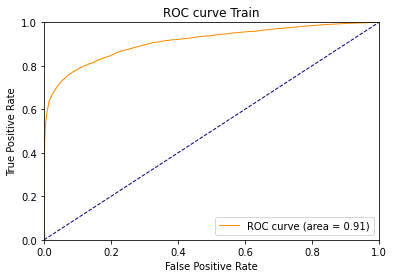

In [29]:
# Строим ROC-кривую
pred_proba_test = model.predict(X_train)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

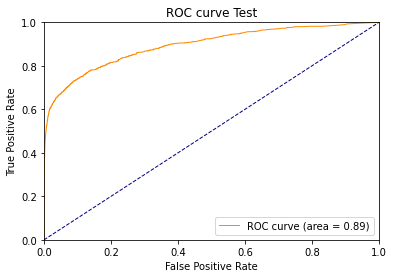

In [30]:
# Строим ROC-кривую
pred_proba_test = model.predict(X_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## LightGBM + Категориальные признаки-1

**Задание 5:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [31]:
# Посмотрим на категориальные признаки
obj_features = train.select_dtypes(include=[np.object])
obj_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [32]:
# Используем get_dummies для преобразования категориальных признаков
obj_dum_features = obj_features.copy()
obj_dum_features = pd.get_dummies(obj_dum_features, dummy_na=True)
obj_dum_features.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1


In [33]:
train = pd.merge(num_features, obj_dum_features, how ='inner', on=num_features.index)
train.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,0,0,0,1,0,0,1,0,0,1
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0,0,0,1,0,0,1,0,0,1


In [34]:
# Разобьем выборку
X_train, X_valid = train_test_split(train, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 544), (36000, 544), (144000,), (36000,))

In [35]:
dtrain = lgb.Dataset(data=X_train, label=y_train)
dvalid = lgb.Dataset(data=X_valid, label=y_valid)

In [36]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": -1,
    "seed": 27
}

In [37]:
# Обучим модель
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=30,
    verbose_eval=10
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32106
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 507
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 30 rounds
[10]	training's auc: 0.834175	valid_1's auc: 0.830768
[20]	training's auc: 0.849071	valid_1's auc: 0.843368
[30]	training's auc: 0.874331	valid_1's auc: 0.869967
[40]	training's auc: 0.879212	valid_1's auc: 0.874786

**Вывод:** На валидационной выборке остановка алгоритма снвоа происходит на 200 итерации. Добавление категориальных фич улучшает качество алгоритма.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

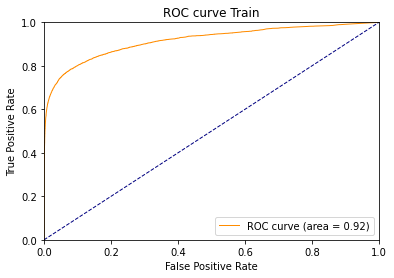

In [38]:
# Строим ROC-кривую
pred_proba_test = model.predict(X_train)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

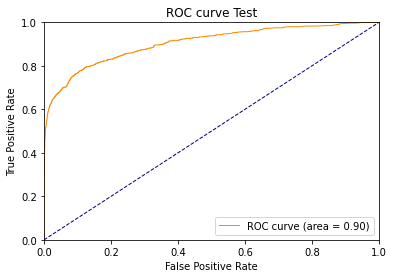

In [39]:
# Строим ROC-кривую
pred_proba_test = model.predict(X_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## LightGBM + Категориальные признаки-2

**Задание 6:** обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [40]:
train = pd.read_csv('./data/assignment_2_train.csv')
test = pd.read_csv('./data/assignment_2_test.csv')

In [41]:
# Выберем только числовые признаки
target = train['isFraud']
num_features = train.select_dtypes(include=[np.number])
num_features = num_features.drop(['isFraud', 'TransactionID'], axis=1)
num_features.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Посмотрим на категориальные признаки
obj_features = obj_features.astype('category')
obj_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [43]:
train = pd.merge(num_features, obj_features, how ='inner', on=num_features.index)
train.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [44]:
# Разобьем выборку
X_train, X_valid = train_test_split(train, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 393), (36000, 393), (144000,), (36000,))

In [45]:
dtrain = lgb.Dataset(data=X_train, label=y_train)
dvalid = lgb.Dataset(data=X_valid, label=y_valid)

In [46]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": -1,
    "seed": 27
}

In [47]:
# Обучим модель
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature='auto',
    early_stopping_rounds=30,
    verbose_eval=10
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32010
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 30 rounds
[10]	training's auc: 0.833948	valid_1's auc: 0.830685
[20]	training's auc: 0.839212	valid_1's auc: 0.834961
[30]	training's auc: 0.869049	valid_1's auc: 0.863018
[40]	training's auc: 0.877463	valid_1's auc: 0.870759
[50]	training's auc: 0.882336	valid_1's auc: 0.87376
[60]	training's auc: 0.885815	valid_1's auc: 0.877186
[70]	training's auc: 0.891671	valid_1's auc: 0.88111

**Вывод:** Остановка также происходит на 200 итерации, качество моделей на предобработанных вручную и встроенным методом категориальных параметрах отличается несущественно.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

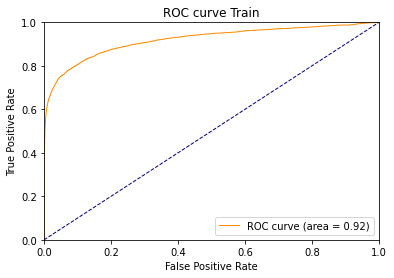

In [48]:
# Строим ROC-кривую
pred_proba_test = model.predict(X_train)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

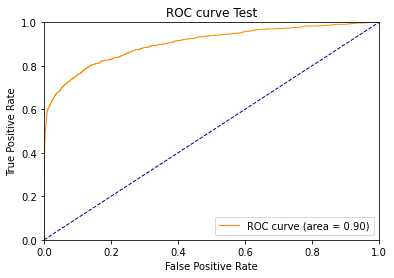

In [49]:
# Строим ROC-кривую
pred_proba_test = model.predict(X_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## CatBoost

**Задание 7:** для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [93]:
train = pd.read_csv('./data/assignment_2_train.csv')
test = pd.read_csv('./data/assignment_2_test.csv')

In [94]:
# Выберем только числовые признаки
target = train['isFraud']
num_features = train.select_dtypes(include=[np.number])
num_features = num_features.drop(['isFraud', 'TransactionID'], axis=1)
num_features.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Разобьем выборку
X_train, X_valid = train_test_split(num_features, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 378), (36000, 378), (144000,), (36000,))

In [53]:
dtrain = cb.Pool(X_train, y_train)
dvalid = cb.Pool(X_valid, y_valid)

In [54]:
params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 30,
    "thread_count": -1,
    "random_seed": 42
}

In [55]:
model = cb.CatBoostClassifier(**params)
model.fit(dtrain, eval_set=dvalid, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5988007	best: 0.5988007 (0)	total: 199ms	remaining: 39.7s
10:	test: 0.7692932	best: 0.7712400 (9)	total: 523ms	remaining: 8.98s
20:	test: 0.7910918	best: 0.7910918 (20)	total: 850ms	remaining: 7.25s
30:	test: 0.8182332	best: 0.8182332 (30)	total: 1.2s	remaining: 6.52s
40:	test: 0.8279320	best: 0.8279904 (39)	total: 1.54s	remaining: 5.96s
50:	test: 0.8329136	best: 0.8332728 (48)	total: 1.89s	remaining: 5.51s
60:	test: 0.8377784	best: 0.8377784 (60)	total: 2.24s	remaining: 5.1s
70:	test: 0.8439150	best: 0.8443191 (66)	total: 2.58s	remaining: 4.68s
80:	test: 0.8468300	best: 0.8468300 (80)	total: 2.94s	remaining: 4.32s
90:	test: 0.8513095	best: 0.8513095 (90)	total: 3.28s	remaining: 3.93s
100:	test: 0.8516722	best: 0.8516975 (99)	total: 3.62s	remaining: 3.55s
110:	test: 0.8544318	best: 0.8544318 (110)	total: 3.96s	remaining: 3.17s
120:	test: 0.8587619	best: 0.8587619 (120)	total: 4.32s	remaining: 2.82s
130:	test: 0.8601428	best: 0.8608701 (128)	total: 4.67s	remaining: 2.46s
140:

**Вывод:** На валидационной выборке остановка алгоритма происходит на 198 итерации.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

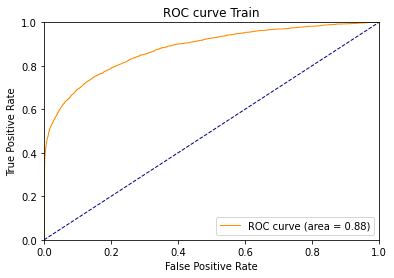

In [56]:
# Строим ROC-кривую встроенными в catboost средствами
fpr, tpr, thresholds = get_roc_curve(model, dtrain, plot=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

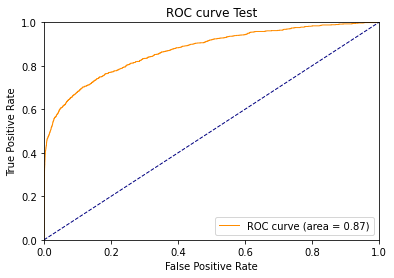

In [57]:
# Строим ROC-кривую встроенными в catboost средствами
fpr, tpr, thresholds = get_roc_curve(model, dvalid, plot=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## CatBoost + Категориальные признаки-1

**Задание 8:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [58]:
# Посмотрим на категориальные признаки
obj_features = train.select_dtypes(include=[np.object])
obj_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [59]:
# Используем get_dummies для преобразования категориальных признаков
obj_dum_features = obj_features.copy()
obj_dum_features = pd.get_dummies(obj_dum_features, dummy_na=True)
obj_dum_features.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1


In [60]:
train = pd.merge(num_features, obj_dum_features, how ='inner', on=num_features.index)
train.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,0,0,0,1,0,0,1,0,0,1
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0,0,0,1,0,0,1,0,0,1


In [61]:
# Разобьем выборку
X_train, X_valid = train_test_split(train, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 544), (36000, 544), (144000,), (36000,))

In [62]:
dtrain = cb.Pool(X_train, y_train)
dvalid = cb.Pool(X_valid, y_valid)

In [63]:
params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 30,
    "thread_count": -1,
    "random_seed": 42
}

In [64]:
model = cb.CatBoostClassifier(**params)
model.fit(dtrain, eval_set=dvalid, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6895082	best: 0.6895082 (0)	total: 38.2ms	remaining: 7.61s
10:	test: 0.7741467	best: 0.7755977 (9)	total: 381ms	remaining: 6.54s
20:	test: 0.8235535	best: 0.8235535 (20)	total: 731ms	remaining: 6.23s
30:	test: 0.8271814	best: 0.8271814 (30)	total: 1.09s	remaining: 5.94s
40:	test: 0.8414060	best: 0.8414060 (40)	total: 1.44s	remaining: 5.57s
50:	test: 0.8520272	best: 0.8520272 (50)	total: 1.8s	remaining: 5.26s
60:	test: 0.8556409	best: 0.8556409 (60)	total: 2.16s	remaining: 4.93s
70:	test: 0.8605583	best: 0.8606257 (68)	total: 2.53s	remaining: 4.6s
80:	test: 0.8626050	best: 0.8626050 (80)	total: 2.91s	remaining: 4.28s
90:	test: 0.8637528	best: 0.8638925 (89)	total: 3.25s	remaining: 3.89s
100:	test: 0.8642872	best: 0.8642872 (100)	total: 3.6s	remaining: 3.53s
110:	test: 0.8660338	best: 0.8660338 (110)	total: 3.96s	remaining: 3.17s
120:	test: 0.8675424	best: 0.8675424 (120)	total: 4.34s	remaining: 2.83s
130:	test: 0.8697315	best: 0.8697315 (130)	total: 4.7s	remaining: 2.47s
140:

**Вывод:** На валидационной выборке остановка алгоритма происходит на 199 итерации. Добавление категориальных фич улучшает качество алгоритма.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

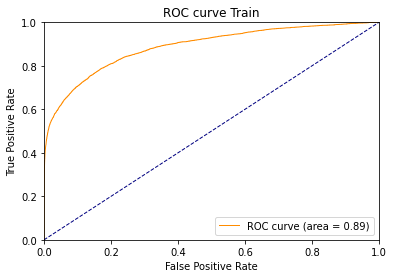

In [65]:
# Строим ROC-кривую встроенными в catboost средствами
fpr, tpr, thresholds = get_roc_curve(model, dtrain, plot=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

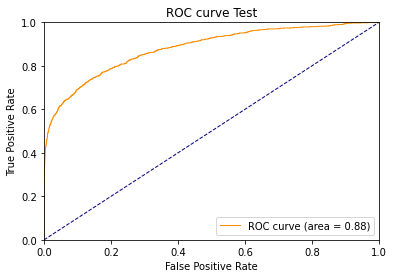

In [66]:
# Строим ROC-кривую встроенными в catboost средствами
fpr, tpr, thresholds = get_roc_curve(model, dvalid, plot=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

## CatBoost + Категориальные признаки-2

**Задание 9:** обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [67]:
train = pd.read_csv('./data/assignment_2_train.csv')
test = pd.read_csv('./data/assignment_2_test.csv')

In [68]:
# Выберем только числовые признаки
target = train['isFraud']
num_features = train.select_dtypes(include=[np.number])
num_features = num_features.drop(['isFraud', 'TransactionID'], axis=1)
num_features.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# Посмотрим на категориальные признаки
obj_features = obj_features.astype('object')
obj_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [70]:
# Получим список признаков object на трейне
obj_feat = list(train.loc[:, train.dtypes == 'object'].columns.values)
obj_feat, len(obj_feat)

(['ProductCD',
  'card4',
  'card6',
  'P_emaildomain',
  'R_emaildomain',
  'M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9'],
 14)

In [71]:
# Преобразуем пропуски в пустое значение и в строку
for feature in obj_feat:
    train[feature] = obj_features.fillna('', inplace=True)
    train[feature] = obj_features.astype('str')

In [72]:
# Получим список признаков object на трейне
obj_feat = list(test.loc[:, test.dtypes == 'object'].columns.values)
obj_feat, len(obj_feat)

(['ProductCD',
  'card4',
  'card6',
  'P_emaildomain',
  'R_emaildomain',
  'M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9'],
 14)

In [73]:
# Преобразуем пропуски в пустое значение и в строку
for feature in obj_feat:
    test[feature] = obj_features.fillna('', inplace=True)
    test[feature] = obj_features[feature].astype('str')

In [74]:
train = pd.merge(num_features, obj_features, how ='inner', on=num_features.index)
train.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,,T,T,T,M2,F,T,,,
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,,,,,M0,T,T,,,


In [75]:
# Разобьем выборку
X_train, X_valid = train_test_split(train, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((144000, 393), (36000, 393), (144000,), (36000,))

In [76]:
dtrain = cb.Pool(X_train, y_train, cat_features=obj_features)
dvalid = cb.Pool(X_valid, y_valid, cat_features=obj_features)

In [77]:
params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 30,
    "thread_count": -1,
    "random_seed": 42
}

In [78]:
model = cb.CatBoostClassifier(**params)
model.fit(dtrain, eval_set=dvalid, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6048554	best: 0.6048554 (0)	total: 115ms	remaining: 23s
10:	test: 0.7495583	best: 0.7505931 (8)	total: 1.49s	remaining: 25.6s
20:	test: 0.8028429	best: 0.8028429 (20)	total: 2.83s	remaining: 24.2s
30:	test: 0.8324833	best: 0.8326551 (28)	total: 4.11s	remaining: 22.4s
40:	test: 0.8372348	best: 0.8372348 (40)	total: 5.57s	remaining: 21.6s
50:	test: 0.8433496	best: 0.8433496 (50)	total: 7s	remaining: 20.4s
60:	test: 0.8483400	best: 0.8483400 (60)	total: 8.36s	remaining: 19.1s
70:	test: 0.8513008	best: 0.8513949 (69)	total: 9.74s	remaining: 17.7s
80:	test: 0.8577944	best: 0.8577944 (80)	total: 11.1s	remaining: 16.3s
90:	test: 0.8609930	best: 0.8613053 (85)	total: 12.5s	remaining: 15s
100:	test: 0.8614129	best: 0.8614129 (100)	total: 13.8s	remaining: 13.5s
110:	test: 0.8630322	best: 0.8630322 (110)	total: 15.1s	remaining: 12.1s
120:	test: 0.8647676	best: 0.8647676 (120)	total: 16.4s	remaining: 10.7s
130:	test: 0.8664856	best: 0.8664856 (130)	total: 17.8s	remaining: 9.39s
140:	tes

**Вывод:** Остановка также происходит на 199 итерации, качество моделей на предобработанных вручную и встроенным методом категориальных параметрах отличается несущественно.

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

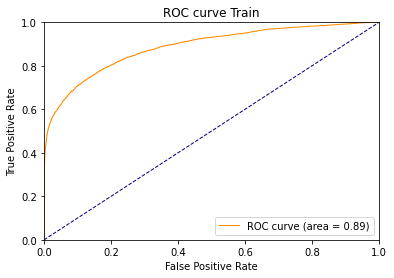

In [79]:
# Строим ROC-кривую встроенными в catboost средствами
fpr, tpr, thresholds = get_roc_curve(model, dtrain, plot=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Train')
plt.legend(loc="lower right")
plt.show()

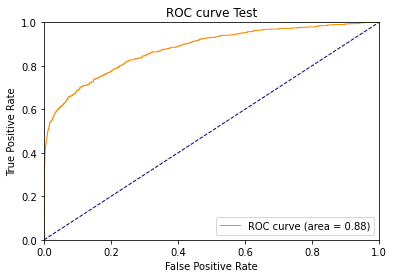

In [80]:
# Строим ROC-кривую встроенными в catboost средствами
fpr, tpr, thresholds = get_roc_curve(model, dvalid, plot=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test')
plt.legend(loc="lower right")
plt.show()

# Задание на повторение

Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

## Задание 1

**Задание 1:** Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

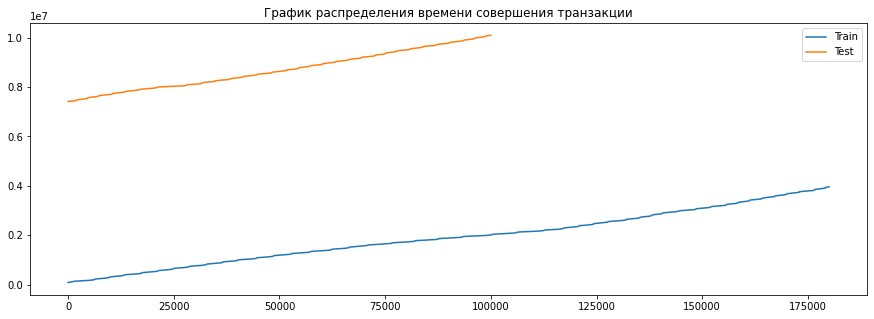

In [95]:
plt.figure(figsize = (15, 5))
plt.plot(train['TransactionDT'])
plt.plot(test['TransactionDT'])

plt.title('График распределения времени совершения транзакции')
plt.legend(labels=['Train', 'Test'])
plt.show()

**Вывод:** данные имеют разный временной промежуток между собою. Можно сказать, что выборки в каком-то смысле независимы и для их оценки подойдет метод Cross-Validation.

## Задание 2

**Задание 2:** построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

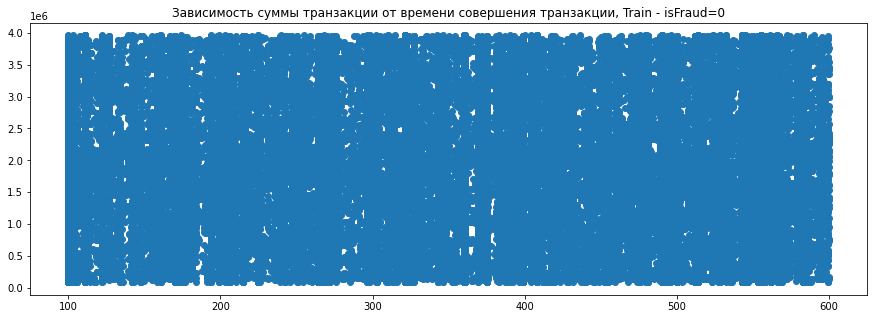

In [102]:
train_t0 = train[train['isFraud']==0].copy()

plt.figure(figsize = (15, 5))
plt.scatter(train_t0.card2, train_t0.TransactionDT)
plt.title('Зависимость суммы транзакции от времени совершения транзакции, Train - isFraud=0')
plt.show()

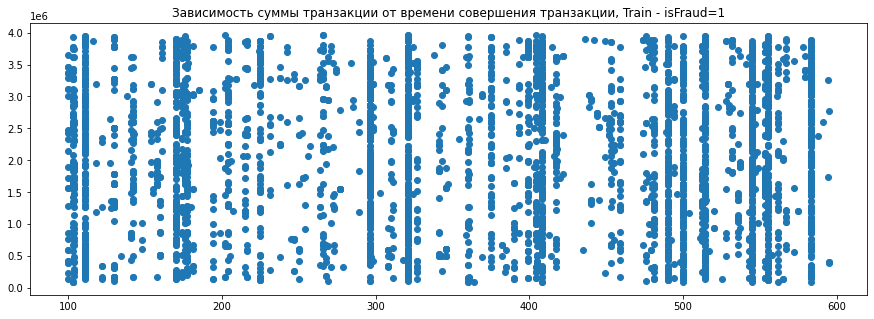

In [103]:
train_t1 = train[train['isFraud']==1].copy()

plt.figure(figsize = (15, 5))
plt.scatter(train_t1.card2, train_t1.TransactionDT)
plt.title('Зависимость суммы транзакции от времени совершения транзакции, Train - isFraud=1')
plt.show()

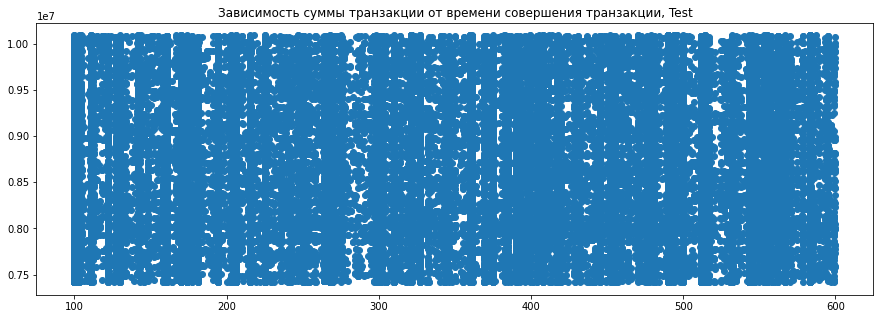

In [104]:
plt.figure(figsize = (15, 5))
plt.scatter(test.card2, test.TransactionDT)
plt.title('Зависимость суммы транзакции от времени совершения транзакции, Test')
plt.show()

**Вывод:** для целевой переменной isFraud=0 наблюдается относительно нормальное распределение транзакций по времени, т.е. какой-то зависимости не наблюдается. В вот для целевой переменной isFraud=1, зависимость суммы транзакции от определенных временных промежутков наблюдается.

## Задание 3

**Задание 3:** построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

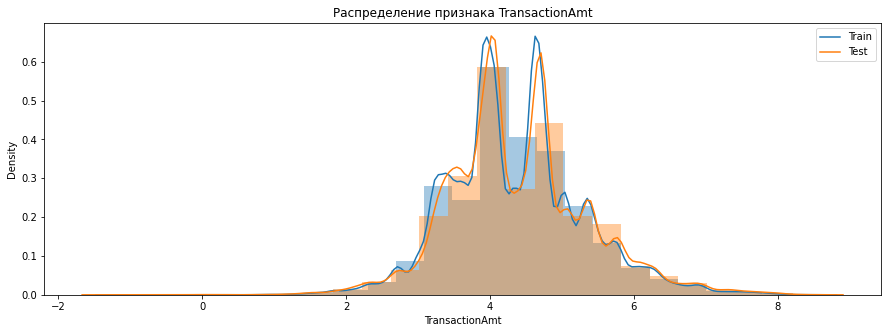

In [106]:
plt.figure(figsize = (15, 5))
sns.distplot(np.log(train['TransactionAmt']), bins=25)
sns.distplot(np.log(test['TransactionAmt']), bins=25)

plt.title('Распределение признака TransactionAmt')
plt.legend(labels=['Train', 'Test'])
plt.show()

**Вывод:** распределение признака TransactionAmt для обеих выборок не является нормальным.

## Задание 4

**Задание 4:** построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

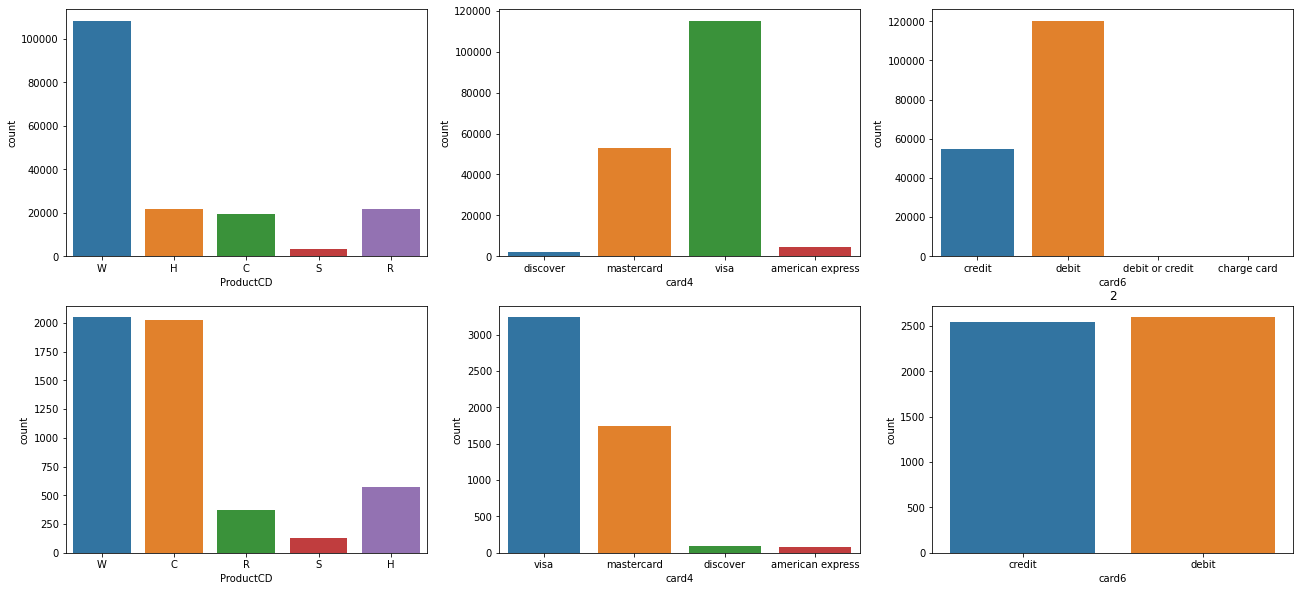

In [128]:
features = ['ProductCD', 'card4', 'card6']
fig, axes = plt.subplots(2, 3, figsize=(22, 10))

for num, feature in enumerate(features):
    df = train[[feature, 'isFraud']]
    df_t0 = df[df['isFraud'] == 0]
    df_t1 = df[df['isFraud'] == 1]
    sns.countplot(x=feature, data=df_t0, ax=axes[0, num])
    sns.countplot(x=feature, data=df_t1, ax=axes[1, num])
    
plt.show()

**Выводы:**  

ProductCD - значения 'W' имеют линейную зависимость от целевой переменной  
card4 - значения 'visa' и 'mastercard' имеют линейную зависимость от целевой переменной  
card6 - целевая переменная равна 0, если признак принимает значения 'debit or credit' или 'charge card'  